#### Writing and Reading Time Series with TimeDB SDK

This notebook demonstrates:
1. Writing time series data without specifying entity_id (auto-generated)
2. Reading data back and plotting with entity_id in legend
3. Writing multiple time series with the same entity_id (updates)
4. Reading back to see consolidated time series


In [25]:
import timedb as td
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta


## Part 1: Two Different Time Series (Different Entity IDs)

First, let's create the schema and write two different time series without specifying entity_id.


In [27]:
# Delete database schema
td.delete()

In [28]:
# Create database schema
td.create()

Creating database schema...
✓ Schema created successfully


In [29]:
# Create first time series: Temperature data (first 24 hours: 0-23)
base_time = datetime(2025, 1, 1, 0, 0, tzinfo=timezone.utc)
dates1 = [base_time + timedelta(hours=i) for i in range(24)]
df1 = pd.DataFrame({
    'valid_time': dates1,
    'value': [20.0 + i * 0.3 for i in range(24)]  # Temperature rising
})

# Insert first time series (entity_id will be auto-generated)
result1 = td.insert_run(df=df1)
print(f"✓ Inserted first time series with entity_id: {result1.entity_id}")
print(f"  Time range: {dates1[0]} to {dates1[-1]}")


Data values inserted successfully.
✓ Inserted first time series with entity_id: 99916b57-08df-4638-9136-1aabcbfc3d90
  Time range: 2025-01-01 00:00:00+00:00 to 2025-01-01 23:00:00+00:00


In [30]:
# Create second time series: Humidity data (next 24 hours: 24-47, following the first)
dates2 = [base_time + timedelta(hours=i) for i in range(24, 48)]  # Hours 24-47
df2 = pd.DataFrame({
    'valid_time': dates2,
    'value': [60.0 - (i-24) * 0.5 for i in range(24, 48)]  # Humidity decreasing
})

# Insert second time series (entity_id will be auto-generated, different from first)
result2 = td.insert_run(df=df2)
print(f"✓ Inserted second time series with entity_id: {result2.entity_id}")
print(f"  Time range: {dates2[0]} to {dates2[-1]}")


Data values inserted successfully.
✓ Inserted second time series with entity_id: 1cdd4999-0aea-42f9-a8ff-f20c0c992fa5
  Time range: 2025-01-02 00:00:00+00:00 to 2025-01-02 23:00:00+00:00


In [31]:
# Read back all time series
df_read = td.read()
print(f"✓ Read {len(df_read)} rows")
print(f"\nDataFrame shape: {df_read.shape}")
print(f"\nEntity IDs in data: {df_read.index.get_level_values('entity_id').unique()}")
print(f"\nFirst few rows:")
print(df_read.head(10))


✓ Read 48 rows

DataFrame shape: (48, 1)

Entity IDs in data: Index([99916b57-08df-4638-9136-1aabcbfc3d90, 1cdd4999-0aea-42f9-a8ff-f20c0c992fa5], dtype='object', name='entity_id')

First few rows:
                                                                          value
valid_time                value_key entity_id                                  
2025-01-01 00:00:00+00:00 value     99916b57-08df-4638-9136-1aabcbfc3d90   20.0
2025-01-01 01:00:00+00:00 value     99916b57-08df-4638-9136-1aabcbfc3d90   20.3
2025-01-01 02:00:00+00:00 value     99916b57-08df-4638-9136-1aabcbfc3d90   20.6
2025-01-01 03:00:00+00:00 value     99916b57-08df-4638-9136-1aabcbfc3d90   20.9
2025-01-01 04:00:00+00:00 value     99916b57-08df-4638-9136-1aabcbfc3d90   21.2
2025-01-01 05:00:00+00:00 value     99916b57-08df-4638-9136-1aabcbfc3d90   21.5
2025-01-01 06:00:00+00:00 value     99916b57-08df-4638-9136-1aabcbfc3d90   21.8
2025-01-01 07:00:00+00:00 value     99916b57-08df-4638-9136-1aabcbfc3d90   22.1
202

/Users/sebaheg/Documents/Github/timedb/timedb/sdk.py:272: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, conn, params=params)


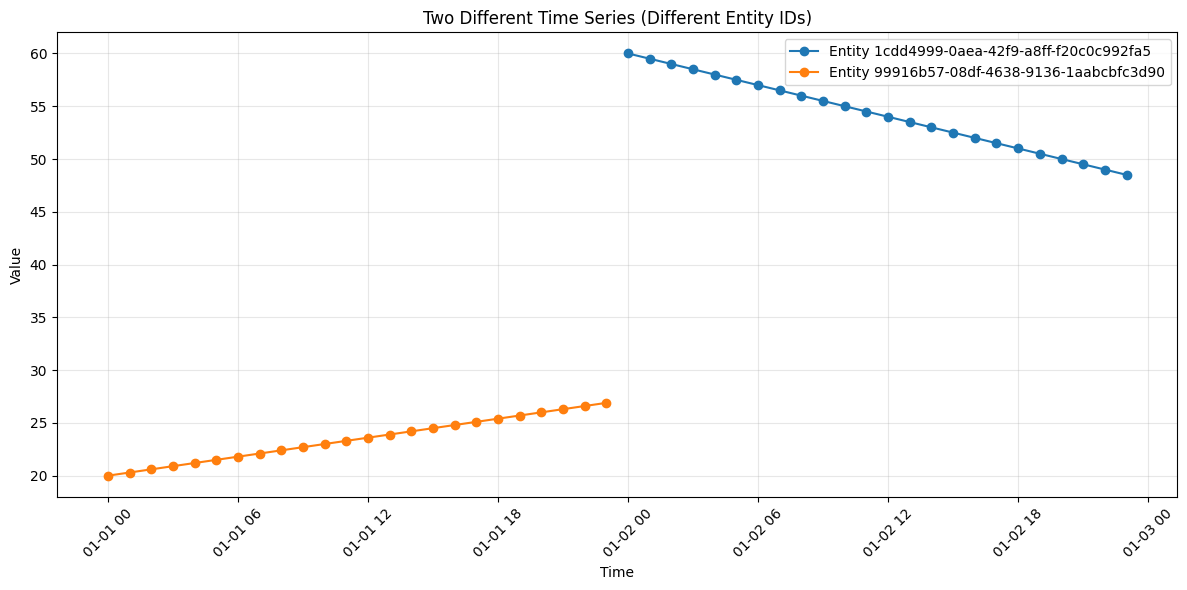


✓ Plotted 2 different time series (different entity_ids)


In [32]:
# Prepare data for plotting
# Reset index to get entity_id as a column
df_plot = df_read.reset_index()

# Handle potential duplicates: if same (valid_time, entity_id, value_key) exists, take the first
# (This shouldn't happen with DISTINCT ON, but just in case)
df_plot = df_plot.drop_duplicates(subset=['valid_time', 'entity_id', 'value_key'])

# Pivot to have entity_id as columns for plotting
df_pivot = df_plot.pivot(index='valid_time', columns='entity_id', values='value')

# Plot both time series
plt.figure(figsize=(12, 6))
for entity_id in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[entity_id], marker='o', label=f'Entity {entity_id}')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Two Different Time Series (Different Entity IDs)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\n✓ Plotted {len(df_pivot.columns)} different time series (different entity_ids)")


## Part 2: Same Entity ID (Consolidated Time Series)

Now let's delete the schema and repeat, but this time we'll use the same entity_id for both writes.


In [33]:
# Delete schema to start fresh
td.delete()

# Create schema again
td.create()

Creating database schema...
✓ Schema created successfully


In [34]:
# Create a shared entity_id
import uuid
shared_entity_id = uuid.uuid4()
print(f"Using shared entity_id: {shared_entity_id}")


Using shared entity_id: 02197af3-03ce-43ed-adf8-b135eb65ae9d


In [ ]:
# Create first time series: Temperature data (first 24 hours: 0-23)
base_time = datetime(2025, 1, 1, 0, 0, tzinfo=timezone.utc)
dates1 = [base_time + timedelta(hours=i) for i in range(24)]
df1 = pd.DataFrame({
    'valid_time': dates1,
    'value': [20.0 + i * 0.3 for i in range(24)]  # Temperature rising
})

# Insert first time series with explicit entity_id
result1 = td.insert_run(df=df1, entity_id=shared_entity_id)
print(f"✓ Inserted first time series with entity_id: {result1.entity_id}")
print(f"  Time range: {dates1[0]} to {dates1[-1]}")


Data values inserted successfully.
✓ Inserted first time series with entity_id: d6673bb6-b3a4-41d4-9638-96a80d8d4d0a


In [ ]:
# Create second time series: Humidity data (next 24 hours: 24-47, following the first, same entity_id)
dates2 = [base_time + timedelta(hours=i) for i in range(24, 48)]  # Hours 24-47
df2 = pd.DataFrame({
    'valid_time': dates2,
    'value': [60.0 - (i-24) * 0.5 for i in range(24, 48)]  # Humidity decreasing
})

# Insert second time series with the SAME entity_id
result2 = td.insert_run(df=df2, entity_id=shared_entity_id)
print(f"✓ Inserted second time series with entity_id: {result2.entity_id}")
print(f"  Time range: {dates2[0]} to {dates2[-1]}")
print(f"  (Same entity_id as first: {result1.entity_id == result2.entity_id})")
print(f"  Note: The two time series will be stitched together since they have consecutive time ranges!")


Data values inserted successfully.
✓ Inserted second time series with entity_id: d6673bb6-b3a4-41d4-9638-96a80d8d4d0a
  (Same entity_id as first: True)


In [22]:
# Read back all time series
df_read = td.read()
print(f"✓ Read {len(df_read)} rows")
print(f"\nDataFrame shape: {df_read.shape}")
print(f"\nEntity IDs in data: {df_read.index.get_level_values('entity_id').unique()}")
print(f"\nFirst few rows:")
print(df_read.head(10))


✓ Read 24 rows

DataFrame shape: (24, 1)

Entity IDs in data: Index([d6673bb6-b3a4-41d4-9638-96a80d8d4d0a], dtype='object', name='entity_id')

First few rows:
                                                                          value
valid_time                value_key entity_id                                  
2025-01-01 00:00:00+00:00 value     d6673bb6-b3a4-41d4-9638-96a80d8d4d0a   60.0
2025-01-01 01:00:00+00:00 value     d6673bb6-b3a4-41d4-9638-96a80d8d4d0a   59.5
2025-01-01 02:00:00+00:00 value     d6673bb6-b3a4-41d4-9638-96a80d8d4d0a   59.0
2025-01-01 03:00:00+00:00 value     d6673bb6-b3a4-41d4-9638-96a80d8d4d0a   58.5
2025-01-01 04:00:00+00:00 value     d6673bb6-b3a4-41d4-9638-96a80d8d4d0a   58.0
2025-01-01 05:00:00+00:00 value     d6673bb6-b3a4-41d4-9638-96a80d8d4d0a   57.5
2025-01-01 06:00:00+00:00 value     d6673bb6-b3a4-41d4-9638-96a80d8d4d0a   57.0
2025-01-01 07:00:00+00:00 value     d6673bb6-b3a4-41d4-9638-96a80d8d4d0a   56.5
2025-01-01 08:00:00+00:00 value     d6673

/Users/sebaheg/Documents/Github/timedb/timedb/sdk.py:272: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(sql, conn, params=params)


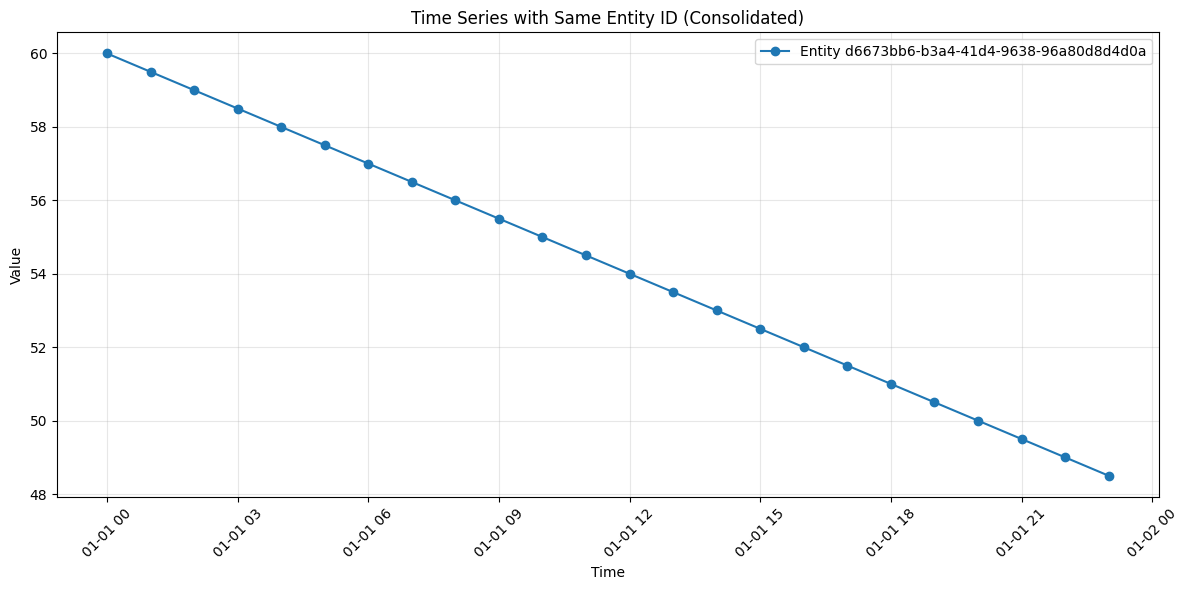


✓ Plotted 1 time series
  Note: Both writes used the same entity_id, so we see one consolidated time series


In [23]:
# Prepare data for plotting
# Reset index to get entity_id as a column
df_plot = df_read.reset_index()

# Handle potential duplicates: if same (valid_time, entity_id, value_key) exists, take the first
# (This shouldn't happen with DISTINCT ON, but just in case)
#f_plot = df_plot.drop_duplicates(subset=['valid_time', 'entity_id', 'value_key'])

# Pivot to have entity_id as columns for plotting
df_pivot = df_plot.pivot(index='valid_time', columns='entity_id', values='value')

# Plot the time series
plt.figure(figsize=(12, 6))
for entity_id in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[entity_id], marker='o', label=f'Entity {entity_id}')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series with Same Entity ID (Consolidated)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\n✓ Plotted {len(df_pivot.columns)} time series")
print(f"  Note: Both writes used the same entity_id, so we see one consolidated time series")
